In [1]:
import gzip
import pandas as pd
import multiprocessing
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# sns.set_style("ticks")
from data_manipulation.reading_util import *

import os
from dotenv import load_dotenv

load_dotenv()


True

In [2]:
def concat_ml_df(env_csv_enzymes:str, env_fasta_non_enzymes:str, length_plot:bool):
    """
    A method for merging our enzymes with non enzymes + adding labels.
    Important: Line 30 resizes non_enzymes df to match the size of enzymes, comment this line out if you have to

    :param env_csv_enzymes: Constant pointing to absolute path of enzymes splitX.csv in .env
    :param env_fasta_non_enzymes: Constant pointing to absolute path of non_emzyme splitX.fasta in .env
    :param length_plot: Optional length comparison
    :return: Df containing both positive and negative samples with labels
    """
    enzymes_path = os.getenv(env_csv_enzymes)
    non_enzymes_path = os.getenv(env_fasta_non_enzymes)

    enzymes = pd.read_csv(enzymes_path, sep=",")
    non_enzymes = read_fasta_to_df(non_enzymes_path)

    enzymes = filter_unwanted_seqs(df=enzymes, enzymes=True)
    enzymes.set_index("Entry", inplace=True)

    non_enzymes = filter_unwanted_seqs(df=non_enzymes, enzymes=False)
    non_enzymes = non_enzymes[non_enzymes["Sequence"].apply(len) <= 1022]

    enzymes["Label"] = 1
    non_enzymes["Label"] = -1
    non_enzymes["EC number"] = -1


    # here I resize non_enzymes to match the size of enzymes
    non_enzymes = non_enzymes.sample(len(enzymes), random_state=42)

    print("Enzyme df size: ", len(enzymes))
    print("Non Enzyme df size: ", len(non_enzymes))

    # combine df to main dataframe for knn
    df = pd.concat([enzymes, non_enzymes])

    if length_plot:
        palette = {1: "tab:cyan", -1: "tab:orange"}
        sns.displot(df, x=df["Sequence"].apply(len), hue="Label", element="step", palette=palette, legend=False, bins=73)
        plt.legend(title='Label', loc='upper right', labels=['Enzyme', 'Non Enzyme'])
        plt.show()

    return df


## Methods used to classify samples based on the sequence length distribution

In [3]:
def pred_seq(sequence:str, inerval_dict: dict) -> int:
    """
    :param sequence: AA sequence
    :param inerval_dict: A dict containing each bin / interval [KEY] and the probability of a sequence in said interval being an enzyme
           [VALUE]
    :return: 1 means enzyme, -1 means non enzyme
    """
    for i in range(1, 15):
        if 73 * (i-1) <= len(sequence) <= i * 73:
            if random.random() <= inerval_dict[i]:
                return 1
            else:
                return -1


def get_length_dist(ml_df:pd.DataFrame) -> dict:
    """
    NOTE: There are some magic numbers here: our bins are 14 in total and each bin contains 73 seqs. These numbers have to be changed
    depending on how big the input df is.
    :param ml_df: df containing enzymes and non enzymes with the corresponding labels 1 and -1
    :return: a dict with intervals and the probability for a sequence being an enzyme in a given interval
    """
    temp_df = ml_df
    interval_dict = {}
    for i in range(1, 15):
        df_bin = temp_df[temp_df["Sequence"].apply(len) <= i * 73]
        temp_df = temp_df.drop(df_bin.index)
        total = len(df_bin)
        enzymes = len(df_bin[df_bin["Label"] == 1])
        # non_enzymes = total - enzymes
        prob_enzyme = enzymes / total
        interval_dict[i] = prob_enzyme
        # print(i, prob_enzyme)

    return interval_dict


Enzyme df size:  9186
Non Enzyme df size:  9186


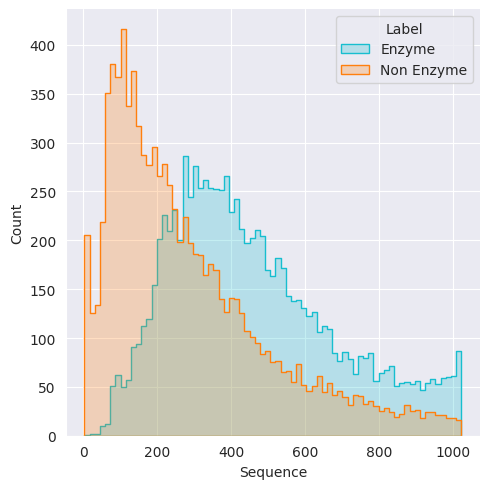

MSPKSVPDIGDVLARQAEDIDTRYHPSAALRRQLNKVFPTHWSFLLGEIALYSFIVLLLTGVYLTLFFDPSMTDVTYNGVYQPLRGVEMSRAYQSTLDISFEVRGGLFVRQIHHWAALMFTAAIMVHLARIFFTGAFRRPRETNWVIGSLLLILAMFEGYFGYSMPDDLLSGIGLRAALSSITLGIPVIGTWLHWALFGGDFPGTILIPRLYALHILLIPGVILALIGLHLALVWFQKHTQFPGPGRTEYNVVGVRVMPVFAFKSGAFFAAIVGVLGLMGGFLQINPIWNLGPYKPSQVSAGSQPDFYMMWTEGLARIWPAWEFYFWHHTIPAPVWVAVIMALVFVLLITYPFLEKRFTGDYAHHNLLQRPRDVPVRTSIGAMAITFYMVLTLAAMNDIIALKFHISLNATTWIGRIGMVILPLLVYFITYRWCIGLQRSDRAVLEHGIETGIIKRLPHGAYIELHQPLGPVDDHGHPIPLEYQGTAVPKRMNKLGSAGSPSSGSFLFADPVSEDAALREATHVAEQRALTALREHQDSIASSPNGERGKH
1


In [4]:

ml_df = concat_ml_df("CSV30_ENZYMES", "FASTA_NON_ENZYMES", True)

train_x, test_x, train_y, test_y = train_test_split(ml_df["Sequence"], ml_df["Label"], random_state=42, test_size=0.3)

print(train_x[0])
print(train_y[0])

train_x_list = train_x.tolist()
test_x_list = test_x.tolist()

NUM_PROCESSES = 16

# Creating ncd data (computationally very expensive)

In [9]:
def ncd(x:str, x2:str) -> float:
    """
    A method which takes in two seqs and calculates the normalized compression distance (ncd)
    :param x: Sequence 1
    :param x2: Sequence 2
    :return: Ncd
    """
    x_compressed = len(gzip.compress(x.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))
    xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
    return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

In [10]:
# Initialize NCD matrices
train_ncd = [[0] * len(train_x_list) for _ in range(len(train_x_list))]
test_ncd = [[0] * len(train_x_list) for _ in range(len(test_x_list))]

In [11]:
# Helper function to compute NCD row
def calculate_ncd_row(data_row): # data row is a tuple of (index, text)
    i = data_row[0] # index of the data and data_row[1] is the text data
    # calcs the row of NCD values for the given data sample
    row = [ncd(data_row[1], train_x_list[j]) for j in range(len(train_x_list))]
    return i, row # return index and row's ncd values

In [12]:
with multiprocessing.Pool(NUM_PROCESSES) as pool:
    # Compute train NCD
    train_data = list(enumerate(train_x_list))
    train_results = pool.map(calculate_ncd_row, train_data)

    # Compute test NCD
    test_data = list(enumerate(test_x_list))
    test_results = pool.map(calculate_ncd_row, test_data)

In [13]:
# Insert rows into NCD matrices
for i, row in train_results:
    train_ncd[i] = row

for i, row in test_results:
    test_ncd[i] = row

# Write ncd distances to file for later use

In [16]:
if not os.path.exists("gzip_data"):
    os.mkdir("gzip_data")

f = open("gzip_data/train_ncd.txt", "w")
f.truncate()
for line in train_ncd:
    f.write(str(line))
    f.write()
f.close()

f = open("gzip_data/test_ncd.txt", "w")
f.truncate()
for line in test_ncd:
    f.write(str(line))
    f.write()
f.close()


# Read in computed ncd data

In [5]:
path_to_test_ncd = os.getenv("TEST_NCD")
path_to_train_ncd = os.getenv("TRAIN_NCD")

with open(path_to_test_ncd) as test_ncd_txt:
    test_ncd = []
    for line in test_ncd_txt:
        test_ncd.append(eval(line))

with open(path_to_train_ncd) as train_ncd_txt:
    train_ncd = []
    for line in train_ncd_txt:
        train_ncd.append(eval(line))


# Train KNN and compute ROC curve and AUC

In [6]:
# K = 15
for K in [3, 5, 7, 9, 11, 13, 15, 17]:
# KNN classification
    neigh = KNeighborsClassifier(n_neighbors=K)

    neigh.fit(train_ncd, train_y)
    accuracy = neigh.score(test_ncd, test_y)
    predictions = neigh.predict(test_ncd)
    f1 = f1_score(test_y, predictions)

    # Predict probabilities for the positive class (class 1)
    y_prob = neigh.predict_proba(test_ncd)[:, 1]

    # Compute ROC curve and AUC for gzip_knn
    fpr, tpr, thresholds = roc_curve(test_y, y_prob)
    roc_auc = auc(fpr, tpr)
    # creates a csv file with the following structure:
    # 1     fpr
    # 2     tpr
    # 3     roc_auc
    # 4     accuracy
    # 5     f1
    scores = open(f"gzip_data/{K}_scores.csv", "w")
    scores.truncate()
    fpr_list = [x for x in fpr]
    scores.write(str(fpr_list))
    scores.write("\n")
    tpr_list = [x for x in tpr]
    scores.write(str(tpr_list))
    scores.write("\n")
    scores.write(str(roc_auc))
    scores.write("\n")
    scores.write(str(accuracy))
    scores.write("\n")
    scores.write(str(f1))
    scores.close()

# Initialize random classifier based on length distribution

In [7]:
interval_dict = get_length_dist(ml_df)

# Initialize arrays to store all predicted scores and actual labels
all_pred_scores = []
all_actual_labels = []

for seq in ml_df["Sequence"]:
    pred = pred_seq(seq, inerval_dict=interval_dict)
    actual_label = ml_df[ml_df["Sequence"] == seq]["Label"][0]
    all_pred_scores.append(pred)
    all_actual_labels.append(actual_label)

# Calculate ROC curve and AUC for classifying samples based on their length
fpr_l, tpr_l, thresholds_l = roc_curve(all_actual_labels, all_pred_scores)
roc_auc_l = auc(fpr_l, tpr_l)


# Read in results

In [8]:
results = []
for K in [3, 5, 7, 9, 11, 13, 15, 17]:
    print(K)
    with open(f"gzip_data/{K}_scores.csv") as scores:
        lines = scores.readlines()
        fpr = eval(lines[0].lstrip("\n"))
        tpr = eval(lines[1].lstrip("\n"))
        roc_auc = float(lines[2].lstrip("\n"))
        accuracy = float(lines[3].lstrip("\n"))
        f1 = float(lines[4].lstrip("\n"))
        results.append([fpr, tpr, roc_auc, accuracy, f1])
        scores.close()

print(results)

3
5
7
9
11
13
15
17
[[[0.0, 0.12576797976147452, 0.36826888326707624, 0.6498012287676184, 1.0], [0.0, 0.33224043715846996, 0.7096539162112933, 0.922040072859745, 1.0], 0.7134581191416137, 0.6705370101596516, 0.6820728291316527], [[0.0, 0.057824358511022765, 0.1886519696422118, 0.3805565594506686, 0.5634260932417781, 0.7538850740874593, 1.0], [0.0, 0.17413479052823316, 0.473224043715847, 0.7326047358834245, 0.8918032786885246, 0.9712204007285975, 1.0], 0.7315984050904395, 0.6757982583454282, 0.6923739025649854], [[0.0, 0.03324900614383809, 0.10733646548608601, 0.23455005421033612, 0.3783881460065052, 0.5146367907481026, 0.6599204915070473, 0.8066498012287676, 1.0], [0.0, 0.08633879781420765, 0.3129326047358834, 0.5704918032786885, 0.7602914389799635, 0.8797814207650273, 0.9559198542805101, 0.9865209471766849, 1.0], 0.7477574958050349, 0.6906748911465893, 0.7099846912740262], [[0.0, 0.0187929165160824, 0.06830502349114564, 0.14817491868449584, 0.2623780267437658, 0.3798337549692808, 0.49

Plotting for k=3, ROC=0.7134581191416137
X values: [0.0, 0.12576797976147452, 0.36826888326707624, 0.6498012287676184, 1.0]
Y values: [0.0, 0.33224043715846996, 0.7096539162112933, 0.922040072859745, 1.0]
Plotting for k=5, ROC=0.7315984050904395
X values: [0.0, 0.057824358511022765, 0.1886519696422118, 0.3805565594506686, 0.5634260932417781, 0.7538850740874593, 1.0]
Y values: [0.0, 0.17413479052823316, 0.473224043715847, 0.7326047358834245, 0.8918032786885246, 0.9712204007285975, 1.0]
Plotting for k=7, ROC=0.7477574958050349
X values: [0.0, 0.03324900614383809, 0.10733646548608601, 0.23455005421033612, 0.3783881460065052, 0.5146367907481026, 0.6599204915070473, 0.8066498012287676, 1.0]
Y values: [0.0, 0.08633879781420765, 0.3129326047358834, 0.5704918032786885, 0.7602914389799635, 0.8797814207650273, 0.9559198542805101, 0.9865209471766849, 1.0]
Plotting for k=9, ROC=0.7539143680760036
X values: [0.0, 0.0187929165160824, 0.06830502349114564, 0.14817491868449584, 0.2623780267437658, 0.37

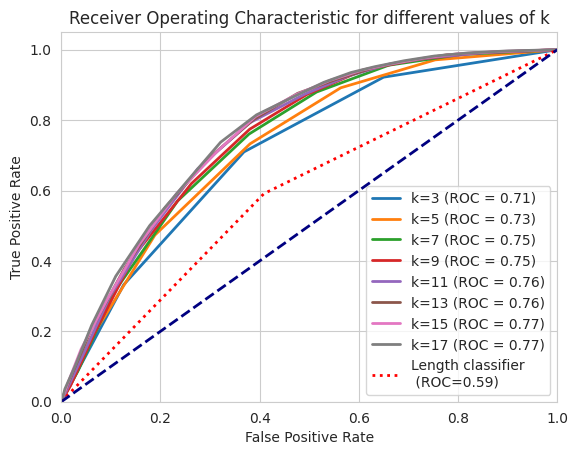

In [10]:
# Plot ROC curve
plt.figure()
k = 1

for res in results:
    k += 2
    print(f"Plotting for k={k}, ROC={res[2]}")
    print("X values:", res[0])
    print("Y values:", res[1])
    plt.plot(res[0], res[1], lw=2, label=f'k={k} (ROC = %0.2f)' % res[2])
    # plt.plot(fpr_5, tpr_5, lw=2, label='k = 5 (ROC = %0.2f)' % auc_5)
plt.plot(fpr_l, tpr_l, color='red', lw=2, linestyle=":", label='Length classifier \n (ROC=%0.2f)' % roc_auc_l)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'Receiver Operating Characteristic for different values of k')
plt.legend(loc="lower right")
plt.show()

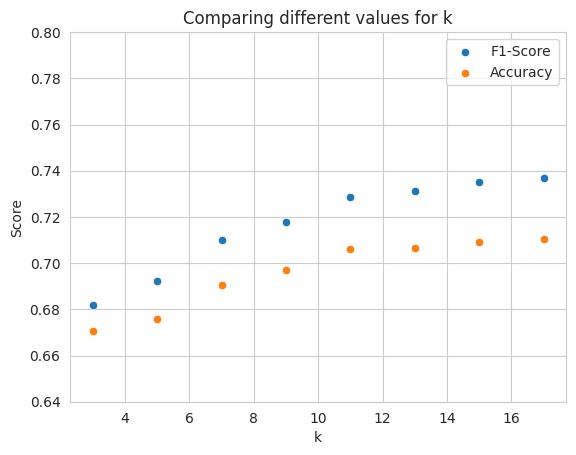

In [12]:
# Plot F1 and acc
ks = [3,5,7,9,11,13,15,17]
accuracies = []
f1_scores = []
for res in results:
    accuracies.append(res[3])
    f1_scores.append(res[4])

ax = plt.gca()
# Create bar plots for F1-Score and Accuracy
sns.scatterplot(x=ks, y=f1_scores, label='F1-Score')
sns.scatterplot(x=ks, y=accuracies, label='Accuracy')

# Set plot title and labels
custom_ticks_y = np.arange(0.64, 0.8, 0.02)
ax.set_title("Comparing different values for k")
ax.set_xlabel("k")
ax.set_ylabel("Score")
plt.yticks(custom_ticks_y)
# Show the plot
plt.show()


# Looking into the sequence compression and distance calculation

In [86]:
x = ml_df["Sequence"][0]
print(f"SEQUENCE:\n---------\n{x}\nLENGTH: {len(x)}\n")
x_comp = gzip.compress(x.encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{x_comp}\n")
print(f"LENGTH: {len(x_comp)}")

SEQUENCE:
---------
MPAPTQLFFPLVRNCELSRIYGTACYCHHKHLCCSPPYIPQNRLRYTPHPAYATFCRPRENWWQYTQGRRYASTPQKFYLTPPQVNSILKANEYSFKVPEFDGKNVSSILGFDSNRLPANAPIEDRRSATTCLQTRGMLLGVFDGHAGCACSQAVSERLFYYIAVSLLPHETLLEIENAVESGRALLPILQWHKHPNDYFSKEASKLYFNGLRTYWQELIDLNTGESADIDVKEALINAFKRLDNDISLEAQVGDPNSFLNYLVLRVAFSGATACVAHVDGVDLHVANTGDSRAMLGVQEEDGSWSAVTLSNDHNAQNERELQRLKLEHPKNEAKSVVKQDRLLGLLMPFRAFGDVKFKWSIDLQKRVIESGPDQLNDNEYTKFIPPNYHTPPYLTAEPEVTYHRLRPQDKFLVLATDGLWETMHRQDVVRIVGEYLTGMHHQQPIAVGGYKVTLGQMHGLLTERRAKMSSVFEDQNAATHLIRHAVGNNEFGAVDHERLSKMLSLPEELARMYRDDITIIVVQFNSHVVGAYQNQEQ
LENGTH: 538

COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x14n\xdbd\x02\xff\r\x90[\x0eE1\x04E\xc7&\x87jS\x15\x8f\xc6M\xe7?\x91\xebO\xd8aY\xc7\xc0\xae\xcb\x18&\x15\xfa\x91d\xac\xc7\x17\xbe\xf7\xcd\xb9\xa7|_\x9a\xbde\xae!\xf1\xaeM\x83\x07w|aA\xfa\xfb\xf9\xbb\xce\x11\x0f\xf2\x9a\xef\xf1\xe4\x9ayi.\xd9\xa0\xf4r\xec2\x1a\xc8[+\xbb\xc9\x03\xb3\x17\x19(\xd8"\x8cH\xb8\xf7\x13\xbf\xc1G\x84\xab\x93\x13\xf8\x83/\x1d*)d\xbc\xb7\xba\x

In [85]:
x2 = ml_df["Sequence"][1]
print(f"SEQUENCE:\n---------\n{x2}\nLENGTH: {len(x2)}\n")
x2_comp = gzip.compress(x2.encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{x2_comp}\n")
print(f"LENGTH: {len(x2_comp)}")

SEQUENCE:
---------
MRLGNAYAYCKPSQNVGLKLDLLRGLPGYVGHATSRINRLENQDNYSIKMMRSWPNAYGSALNCSVFDGHGEKGAQLSQLLADKLCSSLDFPEPSWDKQDLKKLVQEYARRFPEGNYWKHKLSTFEKFYNKFIKNCNSKQELLLMKEGDSAILGQNGGRMIFDKMGNIIDKIALLTELDRLRLFYGFARFDLDQCCGLGTAAGSTASSIFLYPYDDPNAPIDEGKDDDSWIISHSGLLKLIVTQVGDSKIILCDQDGIAHALTTTHHINSSRERHRLSIDPSRLDPDAFGETRFLNNFANTRSFGDVAGKPYGISSEPDIFSFLVGNTLHLPRSERSKLPFNGDECFLALVTDGITNKLADQEVVDLITSTVNSWGLKKATPQFVAEETIKFIQAIATKHSDNATCVVVRLSNWGNWPNVDRTGPQRETKLMNAQSNETKLN
LENGTH: 442

COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x0en\xdbd\x02\xff\x15\x90Q\x8aE1\x08C\xd7&\xb5\xb5b\xae\xb4*}t\xff\x1b\x99\xce_\x08\x84$\xe7\x0b\x88\xd3\xa5\xdbl\xe5\xf6#00\x10\x82%\xf7\xc8\xa4\xcaP\x0ft\xdf\xec7\xd5\xbe/\xf2\xb7^D\x92\xe0-\xcf`\x99\xd2Mh#7@lh\x99\xe0\xb1\xfa\xca\x1f\xdbf\x98\xe1\xec~)\xe2\x99\xe2\xf7g\xd3\x905\xba\x8d\xeb6\xd4\xbcy\xda\xee\x00>\xeb\xc2I\n\xd9.\x12\x9f\x0e\xb6O\\\x95M\t\xa8\x0e\x0e\x04\xc6\x95A1\x18\xbc[\x13H\x11I\x16e\xea\xc0]\x97\xf9-\\\xca]\x8c\x99\xf3\xa7\x9a3\x05\xef\

## Combining x and x2 to xx2

In [58]:
xx2_comp = gzip.compress(" ".join([x, x2]).encode())
print(f"COMPRESSED SEQUENCE:\n--------------------\n{xx2_comp}\n")
print(f"LENGTH: {len(xx2_comp)}")


COMPRESSED SEQUENCE:
--------------------
b'\x1f\x8b\x08\x00\x99a\xdbd\x02\xff\x1d\x93Q\xae\xed \x08E\xa7\xf2\xa6B\n\xa2\x81\x12\x04b\xe3\xfc\'r9\xef\xcfX\xaa\xb0\xf6\xf2u\xf0\xda:\x86\xeb\t{H3\xd6\xe5\x82\xe7>s\xca\xd4\xe7I\xf7\xbb|[h\xdc\xf2\xe9p\xa1\xc6\x13\x1ed\xdf\xb7om\x8e\xb8\x90\xe5[\xc6\xd5r\xdf\xc7r\xa9\x80\xd1\xcd!\xc7i \x8b\x9d\xecM\x1e\x98}\x90\x83\x81/\xc2\x88\x84\xaaGw\x05\xbf\xaa|\xbar\x02?\xf0\xe4\x86\x93\x14:\xee]\xbdR\xf5I\xa5J\x8b\x0c\x0e%\x07\xf4\xd6\xd2\xfdu\x8fnxG\nA\x8a\xdea\xacQ\xf7\xdb\xa4\x0b\xd5\x8a)\x01\x17\x9e\xfe\xac\xcb`H(\x1a\xaeT\x82}\x18\xddr\xa8]=\x1a\x07F2\xf4\xe4\x07\xe6A>\xa8\xf3@\x1f\x80\x19\xf0vo\x9b\x089\xbf\x84S\x9a\x86\xd3`\x1b\x05\xe9\x0e\x15\xa5\xe9b\x04\x92\xe7\xc8\xc6\xe8YT_\x1f\x01\x83\xfb\xee!_v7[\xe2\xacn\xdeq\xaba\xe3)\x19\xcb\xdd\xeelj\x8d\x0e\xc8\xe9\xd4\x9dM\xda7\xca\xe8\xae\xa0\x90\xf5\xa3zgl<\'\xd6a\xeaJ~\xe7\xdc\xdb\x1b\r\xf3\x95n\x88\xf7;\xfb\xca\xa2\x08\x907\xf3\x0c\xc2m\x005u\xc5\xec23\x1a\x0c\x07gCMy5\xd5\x89\x14\xe2\xbd\x81

## Calulating normalized compression distances

In [61]:
# saving lengths
x_comp_length = len(x_comp)
x2_comp_length = len(x2_comp)
xx2_comp_length = len(xx2_comp)


ncd = (xx2_comp_length - min(x_comp_length, x2_comp_length)) / max(x_comp_length, x2_comp_length)
print(f"Normalized compression distance: {ncd}")

Normalized compression distance: 0.9194029850746268


### Now we need to compare every sequence to every other sequence in the dataframe:

In [63]:
def ncd(x, x2):
  x_compressed = len(gzip.compress(x.encode()))
  x2_compressed = len(gzip.compress(x2.encode()))
  xx2 = len(gzip.compress((" ".join([x,x2])).encode()))
  return (xx2 - min(x_compressed, x2_compressed)) / max(x_compressed, x2_compressed)

In [64]:
example_df = ml_df["Sequence"][1:10]
train_ncd = [[ncd(example_df[i], example_df[j]) for j in range(len(example_df))] for i in range(len(example_df))]

In [69]:
for i in range(len(train_ncd)):
    print(f"[{i}]: {train_ncd[i]}")

[0]: [0.04609929078014184, 0.900709219858156, 0.913312693498452, 0.9438669438669439, 0.9477124183006536, 0.9113475177304965, 0.9524714828897338, 0.8936170212765957, 0.8829787234042553]
[1]: [0.9078014184397163, 0.04285714285714286, 0.9256965944272446, 0.9584199584199584, 0.9651416122004357, 0.9142857142857143, 0.9524714828897338, 0.9071428571428571, 0.9]
[2]: [0.9164086687306502, 0.9256965944272446, 0.034055727554179564, 0.9584199584199584, 0.9564270152505446, 0.9287925696594427, 0.9562737642585551, 0.9071207430340558, 0.9009287925696594]
[3]: [0.9438669438669439, 0.9667359667359667, 0.9542619542619543, 0.037422037422037424, 0.9646569646569647, 0.9563409563409564, 0.9600760456273765, 0.9417879417879418, 0.9459459459459459]
[4]: [0.9477124183006536, 0.9651416122004357, 0.9586056644880174, 0.9667359667359667, 0.034858387799564274, 0.9455337690631809, 0.9657794676806084, 0.9498910675381264, 0.9368191721132898]
[5]: [0.9042553191489362, 0.9142857142857143, 0.9287925696594427, 0.96049896049

[0.         0.00433683 0.02168413 0.06107698 0.12757499 0.2088905
 0.29960246 0.38814601 0.47668956 0.55511384 0.62811709 0.70328876
 0.77773762 0.87640043 1.        ]


# Testing if our sequence length classifier method actually works:

In [8]:
interval_dict = get_length_dist(ml_df)
counter = 0
for i in range(10000):
    p = pred_seq("MYHPGRSPSFLITLANVICAAILFDIHTGGYQPGSLIPIVAWMTPFVTLLWLSASFATYLYKYVRTRLLPEEKVARVYYTAQSAPYFDPALGVMMQFAPSHGGASIEVQVNPSWISLLGGSLKINGDDASNESAVLGSFYSSVKPGDEPASLVAIKSGPQTIGFGCRTKIDGDDCLFTANHVWNNSMRPTALAKRGKQVAIEDWETPLSCDHKMLDFVVVRVPKHVWSKLGVKATQLVCPSDKDAVTCYGGSSSDNLLSGTGVCSKVDFSWKLTHSCPTAAGWSGTPIYSSRGVVGMHVGFEDIGKLNRGVNAFYVSNYLLRSQETLPPELSVIEIPFEDVETRSYEFIEVEIKGRGKAKLGKREFAWIPESGKYWADDDDDSLPPPPKVVDGKMVWSSAQETVAEPLNLPAGGRVKALAALSQLAGYDFKEGEAASTRGMPLRFVGQSACKFRELCRKDTPDEVLRATRVFPELSDFSWPERGSKAELHSLLLQAGKFNPTGIPRNLEGACQNLLERYPASKSCYCLRGEAWSFDAVYEEVCKKAQSAEINEKASPGVPLSRLASTNKDLLKRHLELVALCVTERLFLLSEAEDLLDESPVDLVRRGLCDPVRLFVKQEPHASRKVREGRFRLISSVSLVDQLVERMLFGPQNQLEIAEWEHIPSKPGMGLSLRQQAKSLFDDLRVKHSRCPAAEADISGFDWSVQDWELWADVEMRIVLGGFGHKLAKAAQNRFSCFMNSVFQLSDGTLIEQQLPGIMKSGSYCTSSTNSRIRCLMAELIGSPWCIAMGDDSVEGWVDGAKDKYMRLGHTCKDYKPCATTISGRLYEVEFCSHVIREDRCWLASWPKTLFKYLSEGKWFFEDLERDVSSSPHWPRIRHYVVGNTPSPHKTNLQNQSPRYGEEVDKTTVNQGYSEHSGSPGHSIEEAQEPEAAPFCCEAASVYPGWGVHGPYCSGDYGSLT", interval_dict)
    if p == 1:
        counter+=1

print(counter/10000) # this should be ~ 0.767


0.7709


FPR: [0.         0.39825803 1.        ]
TPR: [0.         0.59464461 1.        ]
Thresholds: [ 2  1 -1]


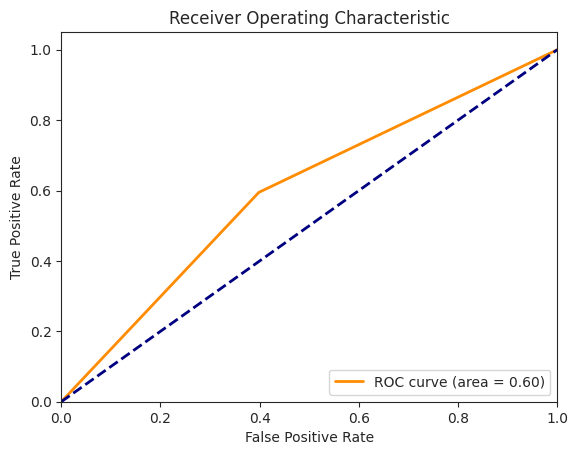

In [19]:
interval_dict = get_length_dist(ml_df)
P = 0
N = 0
TP = 0
TN = 0
FP = 0
FN = 0


# Initialize arrays to store all predicted scores and actual labels
all_pred_scores = []
all_actual_labels = []

for seq in ml_df["Sequence"]:
    pred = pred_seq(seq, inerval_dict=interval_dict)
    actual_label = ml_df[ml_df["Sequence"] == seq]["Label"][0]
    if (pred, actual_label) == (1,1):
        TP += 1
        P += 1
    if (pred, actual_label) == (1,-1):
        FP += 1
        P+=1
    if (pred, actual_label) == (-1,1):
        FN+=1
        N+=1
    if (pred, actual_label) == (-1,-1):
        TN+=1
        N+=1

    all_pred_scores.append(pred)
    all_actual_labels.append(actual_label)


sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / len(ml_df)
precision = TP / (TP + TN)
f_1 = 2* ((precision * sensitivity) / (precision + sensitivity))

# Calculate ROC curve and AUC for the entire dataset
fpr, tpr, thresholds = roc_curve(all_actual_labels, all_pred_scores)
roc_auc = auc(fpr, tpr)

# Print the ROC curve values
print("FPR:", fpr)
print("TPR:", tpr)
print("Thresholds:", thresholds)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()







In [3]:
scores = open(f"test_scores.tsv", "w")
tmp = []
for i in [1,2,3]:
    tmp.append(str(i))
scores.write("\t".join(tmp))
scores.close()